In [4]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Jojo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
img = np.array([[cv2.imread('./se1_b07_1500.jpg',-1),
              cv2.imread('./se1_b07_1510.jpg',-1),
              cv2.imread('./se1_b07_1520.jpg',-1),
              cv2.imread('./se1_b07_1530.jpg',-1)]])
y = cv2.imread('./se1_b07_1540.jpg',-1)

In [6]:
img = img/255
y = y/255

In [4]:
class ConvLSTMCell(tf.nn.rnn_cell.RNNCell):
    """A LSTM cell with convolutions instead of multiplications.
    Reference:
      Xingjian, S. H. I., et al. "Convolutional LSTM network: A machine learning approach for precipitation nowcasting." Advances in Neural Information Processing Systems. 2015.
    """

    def __init__(self, shape, filters, kernel, forget_bias=1.0,
            activation=tf.tanh, normalize=True, peephole=True,
            data_format='channels_last', reuse=None):
        super(ConvLSTMCell, self).__init__(_reuse=reuse)
        self._kernel = kernel
        self._filters = filters
        self._forget_bias = forget_bias
        self._activation = activation
        self._normalize = normalize
        self._peephole = peephole
        if data_format == 'channels_last':
            self._size = tf.TensorShape(shape + [self._filters])
            self._feature_axis = self._size.ndims
            self._data_format = None
        elif data_format == 'channels_first':
            self._size = tf.TensorShape([self._filters] + shape)
            self._feature_axis = 0
            self._data_format = 'NC'
        else:
            raise ValueError('Unknown data_format')
  
    @property
    def state_size(self):
        return tf.nn.rnn_cell.LSTMStateTuple(self._size, self._size)
  
    @property
    def output_size(self):
        return self._size
  
    def call(self, x, state):
        # c: cell h: final state
        c, h = state
  
        x = tf.concat([x, h], axis=self._feature_axis)
        n = x.shape[-1].value
        m = 4 * self._filters if self._filters > 1 else 4
        W = tf.get_variable('kernel', self._kernel + [n, m])
        y = tf.nn.convolution(x, W, 'SAME', data_format=self._data_format)

        if not self._normalize:
            y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
        j, i, f, o = tf.split(y, 4, axis=self._feature_axis)
  
        if self._peephole:
            i += tf.get_variable('W_ci', c.shape[1:]) * c
            f += tf.get_variable('W_cf', c.shape[1:]) * c
  
        if self._normalize:
            j = tf.contrib.layers.layer_norm(j)
            i = tf.contrib.layers.layer_norm(i)
            f = tf.contrib.layers.layer_norm(f)
  
        f = tf.sigmoid(f + self._forget_bias)
        i = tf.sigmoid(i)
        new_c = c * f + i * self._activation(j)

        if self._peephole:
            o += tf.get_variable('W_co', c.shape[1:]) * c

        if self._normalize:
            o = tf.contrib.layers.layer_norm(o)
            c = tf.contrib.layers.layer_norm(c)

        o = tf.sigmoid(o)
        new_h = o * self._activation(c)

        # TODO 
        #tf.summary.histogram('forget_gate', f)
        #tf.summary.histogram('input_gate', i)
        #tf.summary.histogram('output_gate', o)
        #tf.summary.histogram('cell_state', c)

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [5]:
batch_size = 1
seq_max_len = 4
shape = [601, 701]
kernel = [3, 3]
channels = 3
filters = 3

In [6]:
inputs = tf.placeholder(tf.float32, [None, seq_max_len] + shape + [channels])
targets = tf.placeholder(tf.float32, [None] + shape + [channels])
seq_len = tf.placeholder(tf.int32, [None])

In [7]:
cell = ConvLSTMCell(shape, filters, kernel)
'''
outputs, final_state = tf.nn.dynamic_rnn(cell,
                                        inputs,
                                        sequence_length = seq_len,
                                        dtype=inputs.dtype,
                                        time_major=True)
'''

outputs, final_state = tf.nn.dynamic_rnn(cell,
                                        inputs,
                                        dtype=inputs.dtype,
                                        time_major=True)


In [8]:
outputs = tf.transpose(outputs, [1,0,2,3,4])
last = tf.gather(outputs, int(outputs.get_shape()[0]) - 1)
loss = tf.losses.mean_squared_error(targets,last)
opt = tf.train.AdamOptimizer().minimize(loss)

C:\Users\Jojo\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        _, loss_val = sess.run([opt, loss], feed_dict={inputs:img, targets:[y]})
        print(loss_val)
    output = sess.run([last], feed_dict={inputs:img})
    sess.close()

0.1348427
0.1345087
0.13417774
0.1338351
0.13348451
0.1331294
0.13276708
0.13239966
0.13202873
0.13165396
0.13127585
0.13089827
0.13051918
0.13014102
0.12976146
0.12938137
0.12900406
0.12862685
0.1282477
0.12787017
0.12749273
0.12711689
0.12673987
0.12636334
0.12598772
0.12561087
0.12523508
0.12486131
0.12448813
0.12411524
0.12374136
0.123367704
0.12299463
0.12262044
0.1222493
0.12187669
0.121507496
0.12113793
0.12076798
0.12039858
0.120029435
0.11965985
0.11928976
0.11892168
0.11855403
0.11818629
0.11782016
0.1174539
0.11708822
0.11672327
0.116359554
0.11599555
0.11563106
0.11526767
0.11490466
0.11454216
0.11417933
0.11381757
0.11345609
0.11309563
0.11273545
0.11237658
0.11201643
0.111658245
0.1113
0.11094215
0.11058556
0.11022874
0.109871775
0.10951733
0.10916183
0.1088062
0.10845178
0.10809745
0.10774367
0.10739084
0.10703752
0.10668493
0.10633359
0.10598235
0.10563175
0.105281755
0.104931705
0.10458269
0.104234055
0.10388587
0.10353833
0.103191614
0.1028448
0.1024987
0.10215363
0.1

In [19]:
def loop_fn(time, cell_output, cell_state, loop_state):
    emit_output = cell_output  # == None for time == 0

    if cell_output is None:
        next_cell_state = last_enc_state
        next_sampled_onehot = dummy_zero_input
        next_loop_state = output_ta
    else:  # pass the last state to the next
        next_cell_state = cell_state
        next_sampled_input = get_sample(cell_output)  # sampling from multinomial
        next_sampled_onehot = tf.nn.embedding_lookup(embeddings, next_sampled_input)

        next_loop_state = loop_state.write(time - 1, next_sampled_input)

    elements_finished = (time >= cur_batch_time)
    next_input = next_sampled_onehot

    return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)

decoder_emit_ta, _, loop_state_ta = tf.nn.raw_rnn(LSTMCell, loop_fn)

In [14]:
np.array(output).shape

(1, 1, 601, 701, 3)

In [16]:
np.array([y]).shape

(1, 601, 701, 3)

In [17]:
outputs.shape

TensorShape([Dimension(4), Dimension(None), Dimension(601), Dimension(701), Dimension(3)])

In [19]:
outputs.get_shape()[0]

Dimension(4)

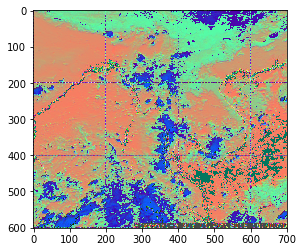

In [21]:
plt.show()

In [20]:
np.unique(output)

array([0.00013251, 0.00015048, 0.00015978, ..., 0.00977622, 0.0097764 ,
       0.0097961 ], dtype=float32)

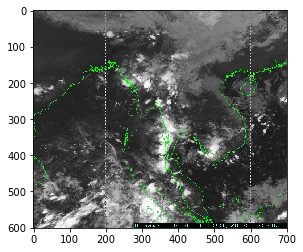

In [8]:
plt.imshow(y)
plt.show()

In [7]:
y

array([[[0.25882353, 0.25882353, 0.25882353],
        [0.74117647, 0.74117647, 0.74117647],
        [0.72941176, 0.72941176, 0.72941176],
        ...,
        [0.76470588, 0.76470588, 0.76470588],
        [0.22745098, 0.22745098, 0.22745098],
        [0.22745098, 0.22745098, 0.22745098]],

       [[0.27058824, 0.27058824, 0.27058824],
        [0.25490196, 0.25490196, 0.25490196],
        [0.23921569, 0.23921569, 0.23921569],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.23137255, 0.23137255, 0.23137255],
        [0.22745098, 0.22745098, 0.22745098]],

       [[0.21960784, 0.21960784, 0.21960784],
        [0.25490196, 0.25490196, 0.25490196],
        [0.24705882, 0.24705882, 0.24705882],
        ...,
        [0.21176471, 0.21176471, 0.21176471],
        [0.25882353, 0.25882353, 0.25882353],
        [0.21568627, 0.21568627, 0.21568627]],

       ...,

       [[0.33333333, 0.33333333, 0.33333333],
        [0.35686275, 0.35686275, 0.35686275],
        [0.28235294, 0